# Neural Network Classification of Telescope Signals

In [ ]:
import pandas as pd
import numpy as np
from random import randint

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from keras.models import Sequential
from keras.metrics import Precision, Recall, F1Score
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv("data/magic04.csv", index_col=0)
data['class'] = data['class'].replace('g',1.0)
data['class'] = data['class'].replace('h',0.0)
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1.0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1.0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1.0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1.0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1.0


## Define Features and Class

Define the features, classes, and standardize the feature columns

In [ ]:
featureNames = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
classCols = ['class']
classNames = ['h', 'g']
num_features = len(featureNames)
num_outputs = len(classCols)
# for featureName in featureNames:
#     data[featureName] = (data[featureName] - data[featureName].mean()) / data[featureName].std()

# data.head()

## Feature Selection

In [ ]:
for feature in featureNames:
    (r,p) = pearsonr(data[feature], data[classCols])
    print(feature,' r =', r[0], 'p =', p)

fLength  r = -0.30757224620373963 p = 0.0
fWidth  r = -0.2655964388163358 p = 1.7261275200255766e-304
fSize  r = -0.11779459173758182 p = 9.690427369681911e-60
fConc  r = 0.024614509221041733 p = 0.0006864052764991323
fConc1  r = 0.004797273270669878 p = 0.5082489228794462
fAsym  r = 0.17358725739062048 p = 1.4798663724927532e-128
fM3Long  r = 0.19340905100370523 p = 1.0756080256114858e-159
fM3Trans  r = -0.003837198068757369 p = 0.596689796312866
fAlpha  r = -0.4609793933309626 p = 0.0
fDist  r = -0.06520263487388497 p = 2.231012772197107e-19


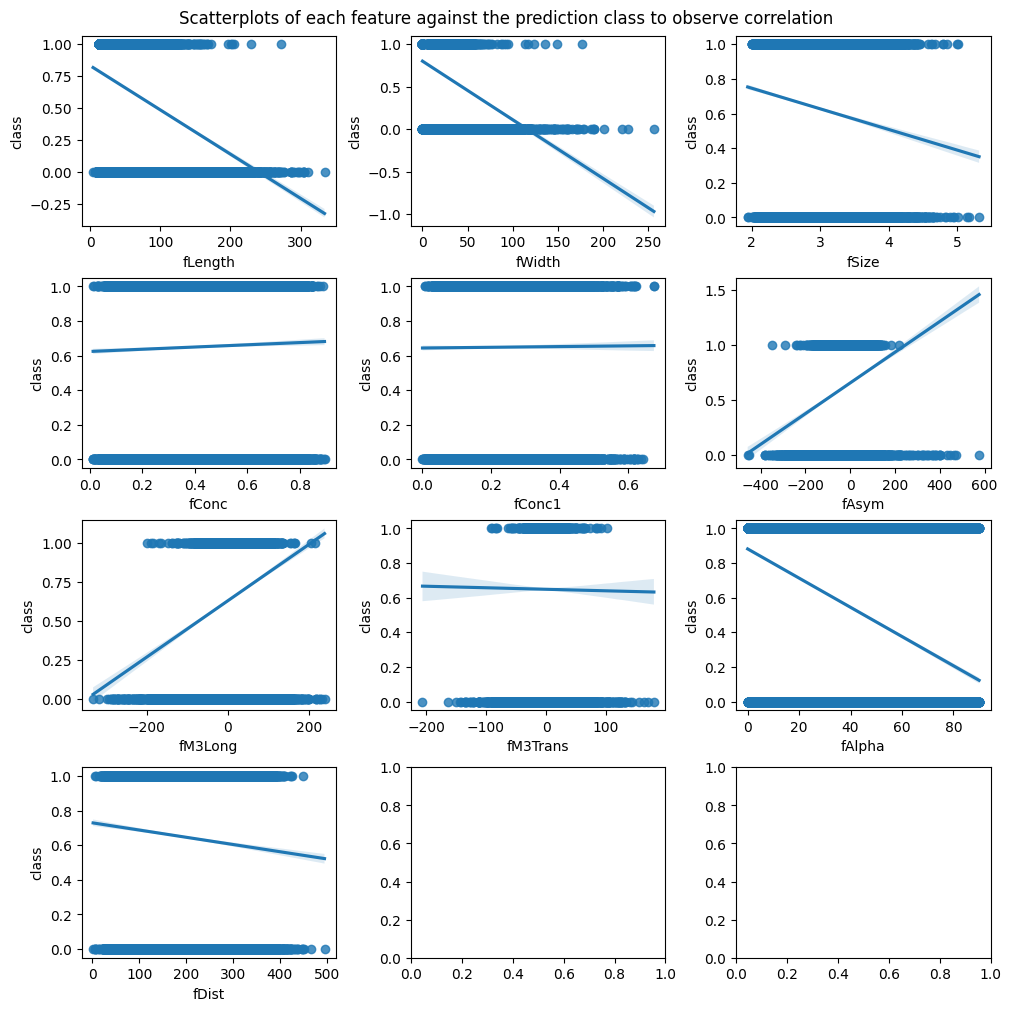

In [ ]:
figSize = (10,10)
figWidth = 3
fig, ax = plt.subplots(len(featureNames)//figWidth+1,figWidth, figsize=figSize, layout='constrained')
for k in range(len(featureNames)):
    i = k // figWidth
    j = k - i * figWidth
    feature = featureNames[k]
    sns.regplot(data=data, x=feature, y="class", ax=ax[i,j])
    # ax[i,j].legend()
    # ax[i,j].set_title(f"Area ID = {areas[k]}, R^2 = {scores[k]}")
plt.suptitle("Scatterplots of each feature against the prediction class to observe correlation")
plt.show()

We can eliminate features with low correlation or high p-value, **however** this does not drastically improve the performance of the model, so we will continue to include all features. 

In [ ]:
# featureNames = ['fLength', 'fWidth', 'fSize', 'fAsym', 'fM3Long', 'fAlpha', 'fDist']
# num_features = len(featureNames)

## Split Data into Training and Testing

In [ ]:
# Get X and y into tensorflow friendly format
X = data[featureNames].values
y = data[classCols].values
# Split
trainX, testX, trainY, testY = train_test_split(X,y)

Standardize:

In [ ]:
scaler = StandardScaler()

# Fit only to the training data - computes the mean and standard deviations
scaler.fit(trainX)

# Now apply the transformations to the data:
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

## Define Neural Network Models

In [ ]:
# Model A: Relatively small, 3 hidden layers
modelA = Sequential()
# Input Layer
modelA.add(Dense(num_features, input_dim=num_features))
# Hidden Layers
modelA.add(Dense(num_features*3))
modelA.add(Dense(num_features*6))
modelA.add(Dense(num_features*3))
modelA.add(Dense(num_features))
modelA.add(Dense(num_features//2))
# Output Layer
modelA.add(Dense(num_outputs, activation='sigmoid'))

# Model B: Add more nodes per layer
modelB = Sequential()
# Input Layer
modelB.add(Dense(num_features, input_dim=num_features))
# Hidden Layers
modelB.add(Dense(num_features*5))
modelB.add(Dense(num_features*10))
modelB.add(Dense(num_features*30))
modelB.add(Dense(num_features*10))
modelB.add(Dense(num_features*5))
modelB.add(Dense(num_features))
# Output Layer
modelB.add(Dense(num_outputs, activation='sigmoid'))

# Model C: Many hidden layers, 2*num_features per node
modelC = Sequential()
# Input Layer
modelC.add(Dense(num_features, input_dim=num_features))
# Hidden Layers
for _ in range(100):
    num_nodes = 2*num_features
    modelC.add(Dense(num_nodes))
    
modelC.add(Dense(num_features))
# Output Layer
modelC.add(Dense(num_outputs, activation='sigmoid'))

# Compile Models
# BinaryCrossEntropy is good for binary classification
modelA.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[Precision(), Recall(), F1Score()])

modelB.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[Precision(), Recall(), F1Score()])

modelC.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[Precision(), Recall(), F1Score()])


## Train Models

In [ ]:
# epochs = 100
epochs = 10

modelA.fit(
    trainX, 
    trainY,
    epochs=epochs,
    verbose=1, 
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

modelB.fit(
    trainX, 
    trainY,
    epochs=epochs,
    verbose=1, 
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

modelC.fit(
    trainX, 
    trainY,
    epochs=epochs,
    verbose=1, 
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/10
357/357 [==============================] - 3s 3ms/step - loss: 0.4925 - precision_15: 0.7872 - recall_15: 0.8799 - f1_score: 0.7871 - val_loss: 0.4541 - val_precision_15: 0.8060 - val_recall_15: 0.9052 - val_f1_score: 0.7831
Epoch 2/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4705 - precision_15: 0.7973 - recall_15: 0.8930 - f1_score: 0.7871 - val_loss: 0.4594 - val_precision_15: 0.7909 - val_recall_15: 0.9188 - val_f1_score: 0.7831
Epoch 3/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4675 - precision_15: 0.7988 - recall_15: 0.8949 - f1_score: 0.7871 - val_loss: 0.4524 - val_precision_15: 0.7946 - val_recall_15: 0.9145 - val_f1_score: 0.7831
Epoch 4/10
357/357 [==============================] - 1s 2ms/step - loss: 0.4656 - precision_15: 0.7979 - recall_15: 0.8955 - f1_score: 0.7871 - val_loss: 0.4527 - val_precision_15: 0.7935 - val_recall_15: 0.9123 - val_f1_score: 0.7831
Epoch 5/10
357/357 [==============================] - 1s

In [ ]:
display(modelA.summary())
display(modelB.summary())
display(modelC.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_596 (Dense)           (None, 10)                110       
                                                                 
 dense_597 (Dense)           (None, 30)                330       
                                                                 
 dense_598 (Dense)           (None, 60)                1860      
                                                                 
 dense_599 (Dense)           (None, 30)                1830      
                                                                 
 dense_600 (Dense)           (None, 10)                310       
                                                                 
 dense_601 (Dense)           (None, 5)                 55        
                                                                 
 dense_602 (Dense)           (None, 1)               

None

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_603 (Dense)           (None, 10)                110       
                                                                 
 dense_604 (Dense)           (None, 50)                550       
                                                                 
 dense_605 (Dense)           (None, 100)               5100      
                                                                 
 dense_606 (Dense)           (None, 300)               30300     
                                                                 
 dense_607 (Dense)           (None, 100)               30100     
                                                                 
 dense_608 (Dense)           (None, 50)                5050      
                                                                 
 dense_609 (Dense)           (None, 10)              

None

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_611 (Dense)           (None, 10)                110       
                                                                 
 dense_612 (Dense)           (None, 20)                220       
                                                                 
 dense_613 (Dense)           (None, 20)                420       
                                                                 
 dense_614 (Dense)           (None, 20)                420       
                                                                 
 dense_615 (Dense)           (None, 20)                420       
                                                                 
 dense_616 (Dense)           (None, 20)                420       
                                                                 
 dense_617 (Dense)           (None, 20)              

None

## Evaluate Models

In [ ]:
resultsA = modelA.evaluate(testX,testY,batch_size=128)
resultsB = modelB.evaluate(testX,testY,batch_size=128)
resultsC = modelC.evaluate(testX,testY,batch_size=128)

predA = modelA.predict(testX)
predB = modelB.predict(testX)
predC = modelC.predict(testX)

149/149 [==============================] - 1s 2ms/step


If output of neural net is >= 0.5, round to 1, else round to 0

In [ ]:
for i in range(len(predA)):
    predA[i] = 1 if predA[i] >= 0.5 else 0
    predB[i] = 1 if predB[i] >= 0.5 else 0
    predC[i] = 1 if predC[i] >= 0.5 else 0


## Precision, Recall, F-Score, Support

In [ ]:
metricsA = precision_recall_fscore_support(testY,predA)
metricsB = precision_recall_fscore_support(testY,predB)
metricsC = precision_recall_fscore_support(testY,predC)

display(metricsA)
display(metricsB)
display(metricsC)

(array([0.75209125, 0.80377907]),
 array([0.59435096, 0.89453251]),
 array([0.6639812 , 0.84673098]),
 array([1664, 3091], dtype=int64))

(array([0.76258993, 0.79737443]),
 array([0.57331731, 0.90391459]),
 array([0.65454545, 0.84730857]),
 array([1664, 3091], dtype=int64))

(array([0.8185567 , 0.77014531]),
 array([0.47716346, 0.9430605 ]),
 array([0.60288535, 0.84787667]),
 array([1664, 3091], dtype=int64))

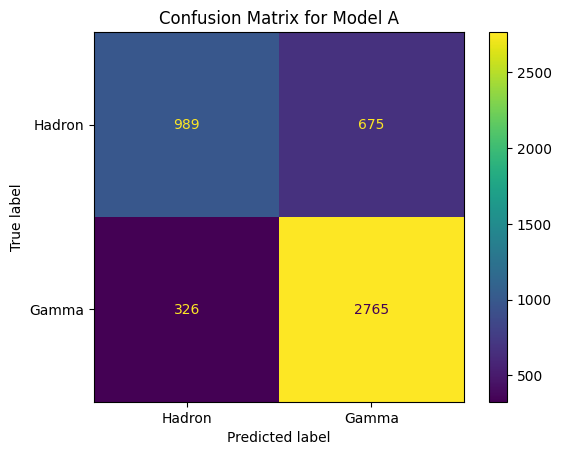

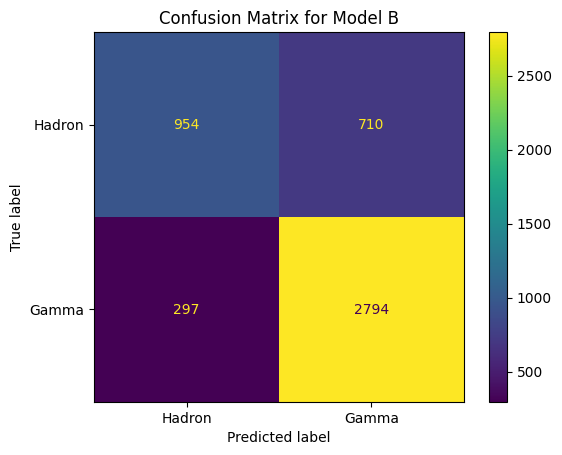

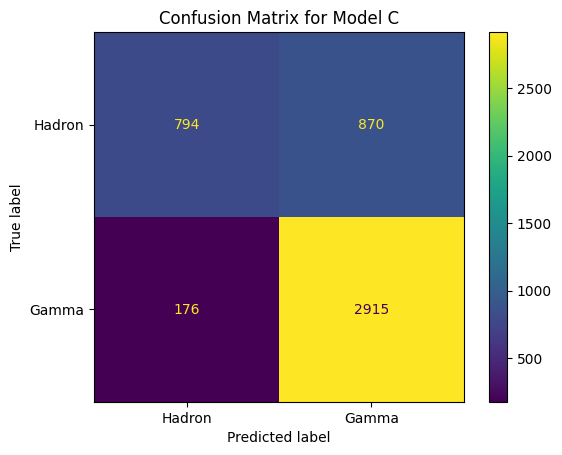

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(testY,predA, display_labels=['Hadron','Gamma'])
disp.ax_.set_title("Confusion Matrix for Model A")
plt.show()
disp = ConfusionMatrixDisplay.from_predictions(testY,predB, display_labels=['Hadron','Gamma'])
disp.ax_.set_title("Confusion Matrix for Model B")
plt.show()
disp = ConfusionMatrixDisplay.from_predictions(testY,predC, display_labels=['Hadron','Gamma'])
disp.ax_.set_title("Confusion Matrix for Model C")
plt.show()

# Decision Tree Classification of Telescope Signals

In [ ]:
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
data = pd.read_csv("data/magic04.csv", index_col=0)
data['class'] = data['class'].replace('g',1)
data['class'] = data['class'].replace('h',0)
display(data.head())

feature_cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist"]
X = data[feature_cols]
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


K so 6688 0s, 12332 1s.
1.  fLength:  continuous  # major axis of ellipse [mm]
2.  fWidth:   continuous  # minor axis of ellipse [mm] 
3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
11.  class:    g,h         # gamma (signal), hadron (background)


In [ ]:
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf = treeclf.fit(X_train, y_train)

In [ ]:
dot = tree.export_graphviz(treeclf, out_file=None, feature_names=feature_cols ,class_names=['0', '1'], filled = True)

graph = Source(dot)
svg = SVG(graph.pipe(format='svg'))
display(svg)

y_pred = treeclf.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
f1_score(y_test, y_pred)



ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Display a confusion matrix:

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Gamma', 'Hadron'], yticklabels=['Gamma', 'Hadron'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

